In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import os

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

from src.utils.time_series_procs import split_sequences
from src.models.transformer_ts_tf import Transformer

In [2]:
def plot_time_series_train_and_prediction_windows(df, model, cut_date):
    index = df['Data/Hora'].shape[0] - df[df['Data/Hora'] == cut_date].index[0] 
    index = -index
    y = df['R28D'].values
    d = df['Data/Hora'].values
    test_series = pd.DataFrame({'ccs28':y}, index=pd.to_datetime(d))
    pred_series = model.predict(x_test)
    diff = pred_series.shape[0] + index
    pred_series = pd.DataFrame({'ccs28-pred' : pred_series.squeeze()}, index=pd.to_datetime(d[index-diff:]))

    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(15, 7))

    test_series.plot(ax=ax)
    ax.axvline(test_series.index[index], color='r') # end of train dataset
    pred_series[index:].plot(ax=ax)
    ax.grid(which="both")
    ax.legend(["train and test series", "end of train series", 'predicted'], loc="upper left")
    ax.set_ylabel('Compressive Strength - MPa', labelpad=20, fontsize=15)
    plt.show()

In [3]:
def get_times_series_data(df, cut_date):
    columns = list(df.columns.drop(['R28D']))
    columns.append('R28D')
    df = df.reindex(columns=columns)
    df['Data/Hora'] = pd.to_datetime(df['Data/Hora'])
    df_train = df[df['Data/Hora'] < cut_date]
    df_test = df[df['Data/Hora'] >= cut_date]
    df_train = df_train.drop(['Data/Hora'], axis=1)
    df_test = df_test.drop(['Data/Hora'], axis=1)
    x_train, y_train = split_sequences(df_train.values, TIME_STEPS)
    x_test, y_test = split_sequences(df_test.values, TIME_STEPS)
    return x_train, y_train, x_test, y_test

In [4]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.5 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [5]:
class StandardScaler3DShape():
    def __init__(self):
        self.scaler = StandardScaler()
    def fit_transform(self,X, y=None):
        X_new = self.scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new
        
    def fit(self,X, y=None):
        X_new = X.reshape(-1, X.shape[-1])
        self.scaler.fit(X_new)
        return self
    
    def transform(self,X,y=None):
        X_new = self.scaler.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
        return X_new

<h3>Force tensorflow use CPU only</h3>

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

<h3>Disable Tensorflow Warnings</h3>

In [7]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [8]:
name = "dados-historicos-partner_i-cement-CPIIE40.csv"
df_r3d_and_r7d = pd.read_csv("../../data/interim/" + "r3d-and-r7d-" + name)
df_r3d_only = pd.read_csv("../../data/interim/" + "r3d-only-" + name)
df_no_r3d_r7d = pd.read_csv("../../data/interim/" + "no-r3d-r7d-" + name)

In [9]:
seed = 47
scaler = StandardScaler()

In [10]:
cut_date = '2021-05-02'
TIME_STEPS = 3
time_steps_list = [1, 3, 5, 7, 10, 15, 20]

# Transformer Encoder

# Baseline models

First we will train a baseline model and verify its overall performance on each of the three datasets.

# Configs:

1. Train Period: [01-01-2019, 2021-05-02)

2. Test Period:  (2021-05-02, 2021-11-31]

3. TIMESTEPS: [1, 3, 5, 7, 10, 15, 20]

4. Epochs: 100

5. Batch size: 32

6. num heads: 2

7. FF Layers enc: 1

      7.1 Units 32

8. Optimization Algorithm: Adam
    
    8.1. Learning Rate: 1e-2

In [11]:
def get_baseline_model(num_features, time_steps, num_heads=2, num_layers_enc=1, num_feed_forward=32):
    model = Transformer(num_hid=num_features,
                        time_steps=time_steps,
                        num_head=num_heads,
                        num_layers_enc=num_layers_enc,
                        num_feed_forward=num_feed_forward)

    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")])
    return model

<h3> Baseline model - Dataset: df_no_r3d_r7d</h3>

In [12]:
df = df_no_r3d_r7d.copy()
x_train, y_train, x_test, y_test = get_times_series_data(df, cut_date)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [13]:
model = get_baseline_model(num_features=x_train.shape[-1], time_steps=x_train.shape[-2])
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 2.138


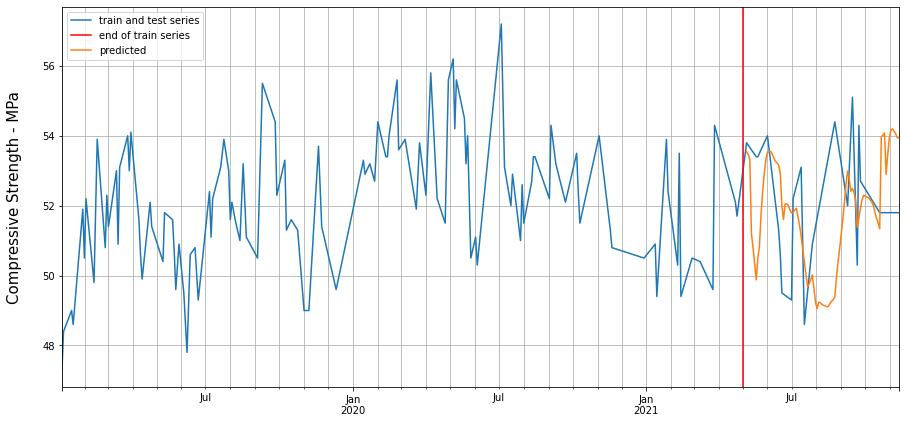

In [14]:
plot_time_series_train_and_prediction_windows(df, model, cut_date)

<h3> Baseline model - Dataset: df_r3d_only</h3>

In [15]:
df = df_r3d_only.copy()
x_train, y_train, x_test, y_test = get_times_series_data(df, cut_date)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [16]:
model = get_baseline_model(num_features=x_train.shape[-1], time_steps=x_train.shape[-2])
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 1.607


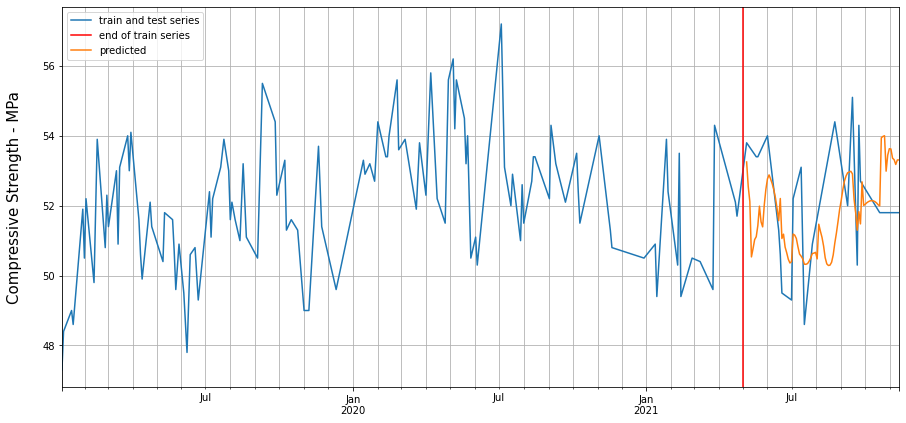

In [17]:
plot_time_series_train_and_prediction_windows(df, model, cut_date)

<h3> Baseline model - Dataset: df_r3d_and_r7d</h3>

In [18]:
df = df_r3d_and_r7d.copy()
x_train, y_train, x_test, y_test = get_times_series_data(df, cut_date)
x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)

In [19]:
model = get_baseline_model(num_features=x_train.shape[-1], time_steps=x_train.shape[-2])
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
rmse = model.evaluate(x_test, y_test, verbose=0)
print('RMSE: %.3f' % rmse[1])

RMSE: 1.696


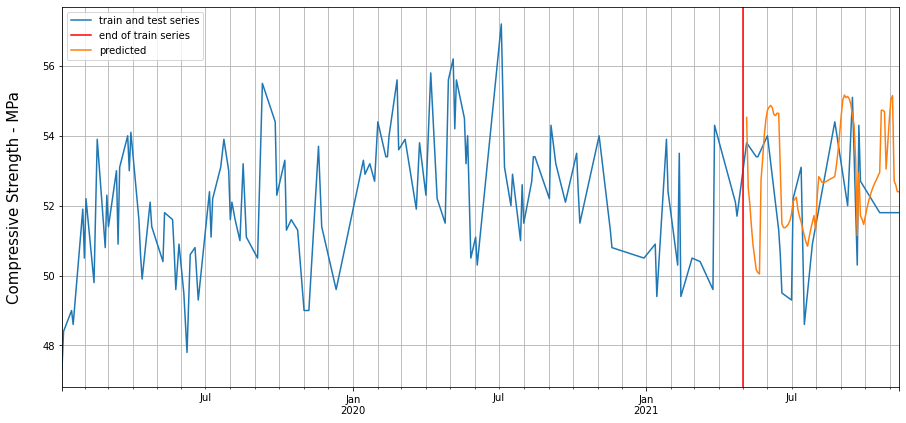

In [20]:
plot_time_series_train_and_prediction_windows(df, model, cut_date)

# Grid Search CV

Before doing Repeated Cross Validation, we shall search for the best parameters. To do so, Keras Tuner will be used
to accomplish the Grid Search.

<h3>GridCV - Scikit Learn</h3>

In [21]:
def create_keras_model(num_features,
                       time_steps,
                       num_heads=2,
                       num_layers_enc=1,
                       num_feed_forward=32,
                       activation='relu',
                       dropout_rate=0.0,
                       learning_rate=1e-3):
    
    model = Transformer(num_hid=num_features,
                        time_steps=time_steps,
                        num_head=num_heads,
                        num_layers_enc=num_layers_enc,
                        num_feed_forward=num_feed_forward,
                        activation=activation,
                        dropout_rate=dropout_rate)
                        
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="mse",
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")])
    return model

In [22]:
def make_grid_search(x, y, TIME_STEPS):
    activation = ['selu', 'relu', 'swish']
    dropout_rate = [0.0, 0.1]
    num_heads = [1, 2, 3,]
    num_layers_enc = [1, 2, 3]
    num_feed_forward = [32]
    learning_rate = [0.001, 0.01, 0.1]
    epochs = [100]
    batches = [32]
    time_steps = [TIME_STEPS]
    num_features = [x.shape[-1]]

    param_grid = dict(model__time_steps=time_steps,
                      model__num_features=num_features,
                      model__num_heads=num_heads,
                      model__num_feed_forward=num_feed_forward,
                      model__num_layers_enc=num_layers_enc,
                      model__activation=activation,
                      model__dropout_rate=dropout_rate, 
                      model__learning_rate=learning_rate,
                      model__epochs=epochs,
                      model__batch_size=batches)

    model = KerasRegressor(build_fn=create_keras_model, epochs=100, batch_size=32, verbose=0)
    pipeline = Pipeline(steps=[('transformer', StandardScaler3DShape()), ('model', model)])

    grid = GridSearchCV(estimator=pipeline, 
                        param_grid=param_grid,
                        n_jobs=-1,
                        cv=3, 
                        scoring='neg_root_mean_squared_error')
    
    grid_result = grid.fit(x, y)

    print("Best: %f using %s\n" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return grid

<h3>GridCV 1</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [23]:
df = df_no_r3d_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

start = time.time()
gridcv1 = make_grid_search(x, y, TIME_STEPS)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

/tmp/ipykernel_1356197/597128074.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=create_keras_model, epochs=100, batch_size=32, verbose=0)


Best: -1.556299 using {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.1, 'model__num_features': 37, 'model__num_feed_forward': 32, 'model__num_heads': 2, 'model__num_layers_enc': 3, 'model__time_steps': 3}

-3.013770 (1.390417) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__num_features': 37, 'model__num_feed_forward': 32, 'model__num_heads': 1, 'model__num_layers_enc': 1, 'model__time_steps': 3}
-13.353819 (16.571009) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__num_features': 37, 'model__num_feed_forward': 32, 'model__num_heads': 1, 'model__num_layers_enc': 2, 'model__time_steps': 3}
-1.774384 (0.198585) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model

In [24]:
gridcv1.best_params_

{'model__activation': 'relu',
 'model__batch_size': 32,
 'model__dropout_rate': 0.0,
 'model__epochs': 100,
 'model__learning_rate': 0.1,
 'model__num_features': 37,
 'model__num_feed_forward': 32,
 'model__num_heads': 2,
 'model__num_layers_enc': 3,
 'model__time_steps': 3}

<h3>GridCV 2</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D is considered.

In [25]:
df = df_r3d_only.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

start = time.time()
gridcv2 = make_grid_search(x, y, TIME_STEPS)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

/tmp/ipykernel_1356197/597128074.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=create_keras_model, epochs=100, batch_size=32, verbose=0)


Best: -1.559950 using {'model__activation': 'swish', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.1, 'model__num_features': 38, 'model__num_feed_forward': 32, 'model__num_heads': 2, 'model__num_layers_enc': 3, 'model__time_steps': 3}

-5.255787 (2.641805) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__num_features': 38, 'model__num_feed_forward': 32, 'model__num_heads': 1, 'model__num_layers_enc': 1, 'model__time_steps': 3}
-1.787911 (0.069329) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__num_features': 38, 'model__num_feed_forward': 32, 'model__num_heads': 1, 'model__num_layers_enc': 2, 'model__time_steps': 3}
-8.094139 (5.809661) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model_

In [26]:
gridcv2.best_params_

{'model__activation': 'swish',
 'model__batch_size': 32,
 'model__dropout_rate': 0.0,
 'model__epochs': 100,
 'model__learning_rate': 0.1,
 'model__num_features': 38,
 'model__num_feed_forward': 32,
 'model__num_heads': 2,
 'model__num_layers_enc': 3,
 'model__time_steps': 3}

<h3>GridCV 3</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset R3D and R7D are considered.

In [27]:
df = df_r3d_and_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

start = time.time()
gridcv3 = make_grid_search(x, y, TIME_STEPS)
end = time.time()
print("\nMinutes Elapsed: ", (end - start)/60)

/tmp/ipykernel_1356197/597128074.py:24: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasRegressor(build_fn=create_keras_model, epochs=100, batch_size=32, verbose=0)


Best: -1.588352 using {'model__activation': 'relu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.1, 'model__num_features': 39, 'model__num_feed_forward': 32, 'model__num_heads': 3, 'model__num_layers_enc': 3, 'model__time_steps': 3}

-7.139633 (3.817900) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__num_features': 39, 'model__num_feed_forward': 32, 'model__num_heads': 1, 'model__num_layers_enc': 1, 'model__time_steps': 3}
-5.001011 (4.195072) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__epochs': 100, 'model__learning_rate': 0.001, 'model__num_features': 39, 'model__num_feed_forward': 32, 'model__num_heads': 1, 'model__num_layers_enc': 2, 'model__time_steps': 3}
-2.001761 (0.162674) with: {'model__activation': 'selu', 'model__batch_size': 32, 'model__dropout_rate': 0.0, 'model__

In [28]:
gridcv3.best_params_

{'model__activation': 'relu',
 'model__batch_size': 32,
 'model__dropout_rate': 0.0,
 'model__epochs': 100,
 'model__learning_rate': 0.1,
 'model__num_features': 39,
 'model__num_feed_forward': 32,
 'model__num_heads': 3,
 'model__num_layers_enc': 3,
 'model__time_steps': 3}

<h2>Times Series KFold Cross validation - Non Canonical Transformer</h2>

Here we will make a Times Series KFold Cross validation with all 3 datasets. Here we are using the <b>Blocking           Time Series Split</b> method. And with timeseries Split method

In [29]:
def make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, grid, repeats=10):
    results = []
    max_samples = x.shape[0]

    activation = grid.best_params_['model__activation']
    dropout_rate = grid.best_params_['model__dropout_rate']
    num_feed_forward = grid.best_params_['model__num_feed_forward']
    num_layers_enc = grid.best_params_['model__num_layers_enc']
    learning_rate = grid.best_params_['model__learning_rate']
    batch_size = grid.best_params_['model__batch_size']
    epochs = grid.best_params_['model__epochs']
    time_steps = grid.best_params_['model__time_steps']
    num_features = grid.best_params_['model__num_features']
    num_heads = grid.best_params_['model__num_heads']
    
    for _ in range(repeats):
        i = 0
        scores = []
        for _ in range(0, max_samples//train_period):
            x_train = x[i:i+train_period]
            y_train = y[i:i+train_period]
            x_test = x[i+train_period: i+train_period+test_period]
            y_test = y[i+train_period: i+train_period+test_period]
            i += train_period
            x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
            x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
            model = Transformer(num_hid=num_features,
                                time_steps=time_steps,
                                num_head=num_heads,
                                num_layers_enc=num_layers_enc,
                                num_feed_forward=num_feed_forward,
                                activation=activation,
                                dropout_rate=dropout_rate)
            model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                          loss="mse",
                          metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")])
            model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
            rmse = model.evaluate(x_test, y_test, verbose=0)
            scores.append(rmse[1])
        results.append(scores)
        print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

    print('\nRMSE: %.3f (%.3f)' % (np.mean(results), np.std(results)))
    return results

<h3> Time Series Repeated KFold Cross Validation Non Canonical Transformer - df_no_r3d_r7d</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [30]:
df = df_no_r3d_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [31]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv1, repeats)

RMSE: 1.623 (0.280)
RMSE: 1.630 (0.390)
RMSE: 1.705 (0.282)
RMSE: 1.605 (0.315)
RMSE: 1.616 (0.333)
RMSE: 1.638 (0.375)
RMSE: 1.645 (0.334)
RMSE: 1.681 (0.333)
RMSE: 1.713 (0.385)
RMSE: 1.744 (0.266)

RMSE: 1.660 (0.335)


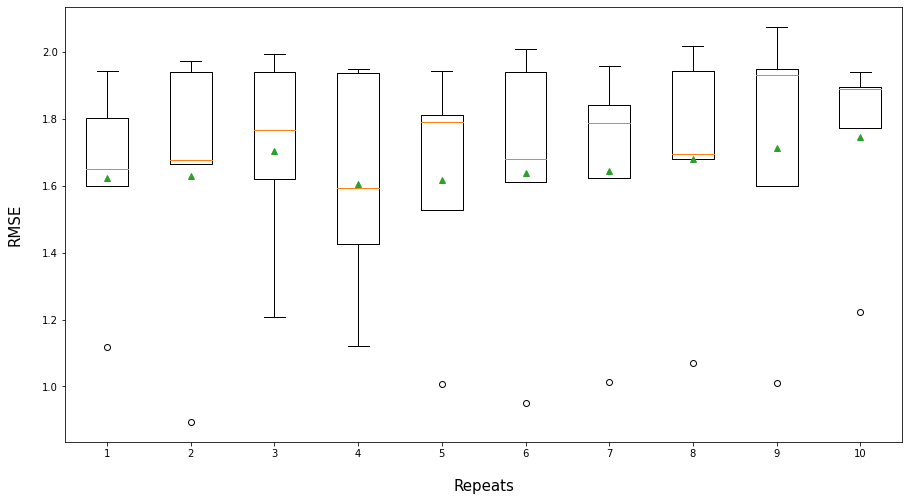

In [32]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [33]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv1, repeats)

RMSE: 1.110 (0.228)
RMSE: 0.926 (0.241)
RMSE: 1.162 (0.525)
RMSE: 1.545 (0.448)
RMSE: 1.380 (0.144)
RMSE: 1.486 (0.241)
RMSE: 1.271 (0.033)
RMSE: 1.565 (0.551)
RMSE: 1.207 (0.110)
RMSE: 1.102 (0.212)

RMSE: 1.275 (0.379)


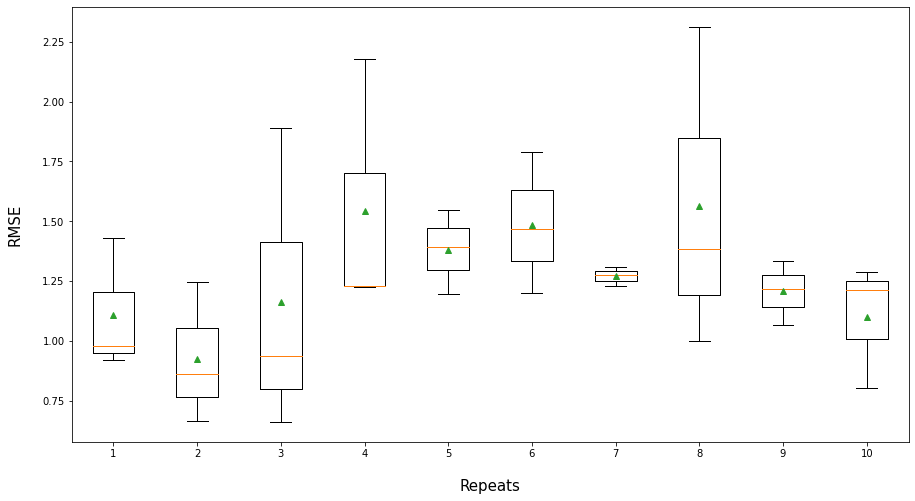

In [34]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [35]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv1, repeats)

RMSE: 0.640 (0.000)
RMSE: 0.604 (0.000)
RMSE: 1.291 (0.000)
RMSE: 1.332 (0.000)
RMSE: 0.590 (0.000)
RMSE: 0.532 (0.000)
RMSE: 0.846 (0.000)
RMSE: 0.731 (0.000)
RMSE: 1.615 (0.000)
RMSE: 0.657 (0.000)

RMSE: 0.884 (0.364)


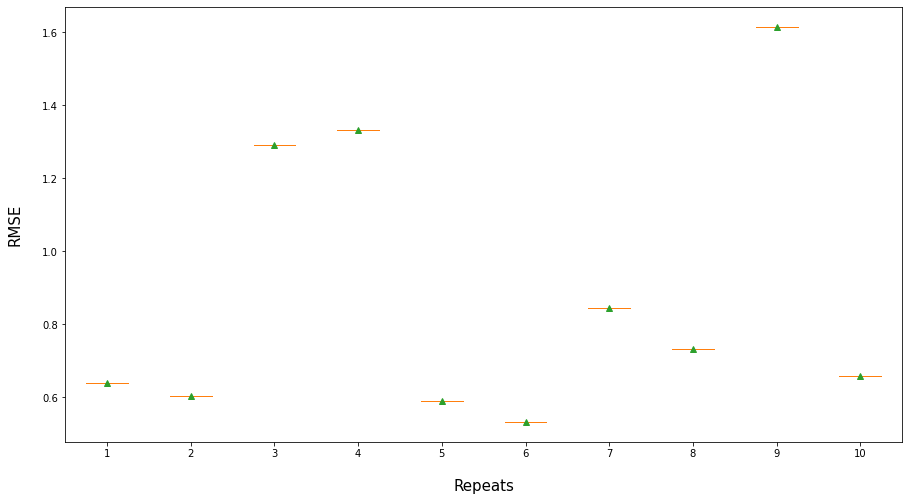

In [36]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h3> Time Series Repeated KFold Cross Validation - df_r3d_only</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D variable is considered.

In [37]:
df = df_r3d_only.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [38]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv2, repeats)

RMSE: 1.693 (0.246)
RMSE: 1.807 (0.363)
RMSE: 1.719 (0.289)
RMSE: 1.648 (0.315)
RMSE: 1.658 (0.374)
RMSE: 1.721 (0.263)
RMSE: 1.742 (0.219)
RMSE: 1.643 (0.295)
RMSE: 1.616 (0.303)
RMSE: 1.712 (0.385)

RMSE: 1.696 (0.314)


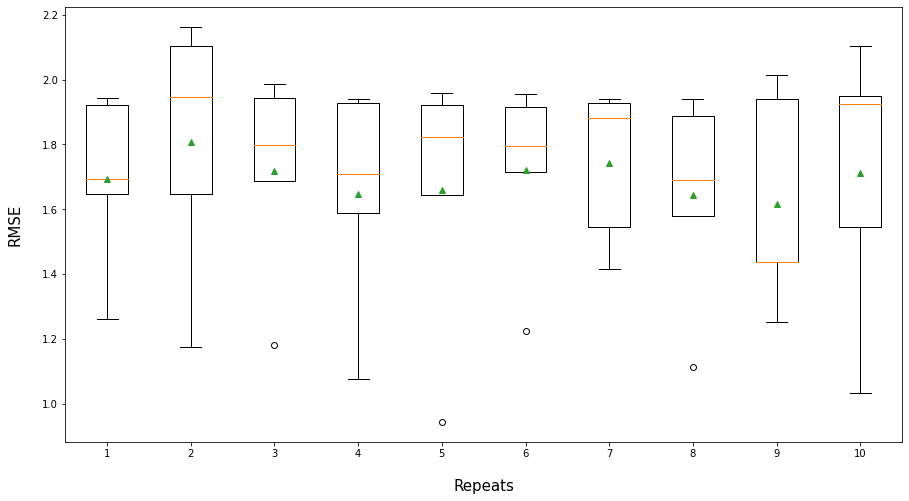

In [39]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [40]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv2, repeats)

RMSE: 1.054 (0.323)
RMSE: 1.366 (0.582)
RMSE: 1.228 (0.295)
RMSE: 1.758 (0.210)
RMSE: 1.159 (0.472)
RMSE: 0.936 (0.261)
RMSE: 1.757 (0.377)
RMSE: 1.336 (0.671)
RMSE: 0.909 (0.312)
RMSE: 1.216 (0.324)

RMSE: 1.272 (0.495)


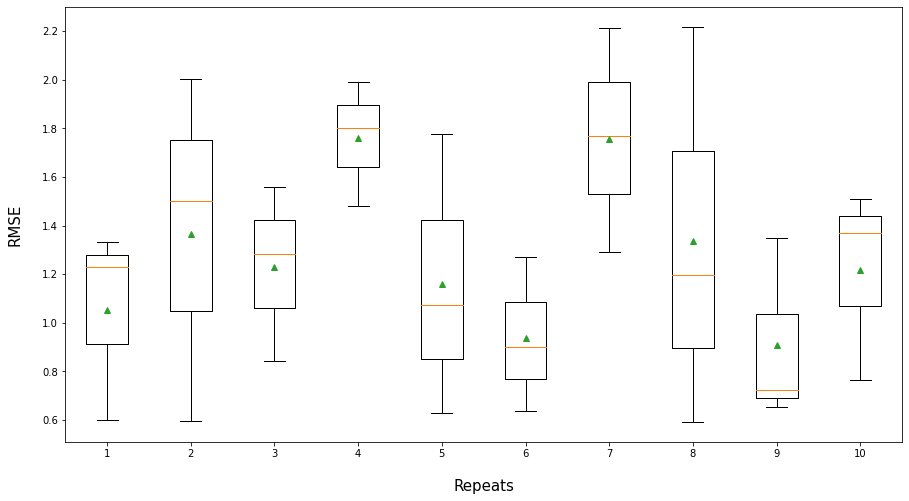

In [41]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [42]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv2, repeats)

RMSE: 1.397 (0.000)
RMSE: 0.960 (0.000)
RMSE: 0.825 (0.000)
RMSE: 1.582 (0.000)
RMSE: 0.990 (0.000)
RMSE: 0.970 (0.000)
RMSE: 1.706 (0.000)
RMSE: 1.281 (0.000)
RMSE: 0.703 (0.000)
RMSE: 0.639 (0.000)

RMSE: 1.105 (0.348)


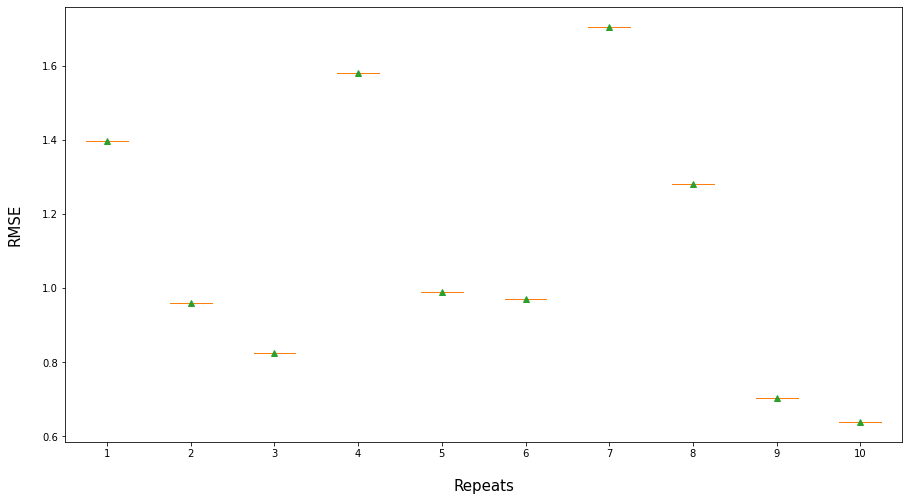

In [43]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h3> Time Series Repeated KFold Cross Validation - df_r3d_and_r7d</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D variables are considered.

In [44]:
df = df_r3d_and_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [45]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv3, repeats)

RMSE: 1.647 (0.331)
RMSE: 1.691 (0.266)
RMSE: 1.634 (0.248)
RMSE: 1.638 (0.350)
RMSE: 1.603 (0.388)
RMSE: 1.589 (0.329)
RMSE: 1.671 (0.282)
RMSE: 1.650 (0.330)
RMSE: 1.689 (0.276)
RMSE: 1.677 (0.274)

RMSE: 1.649 (0.312)


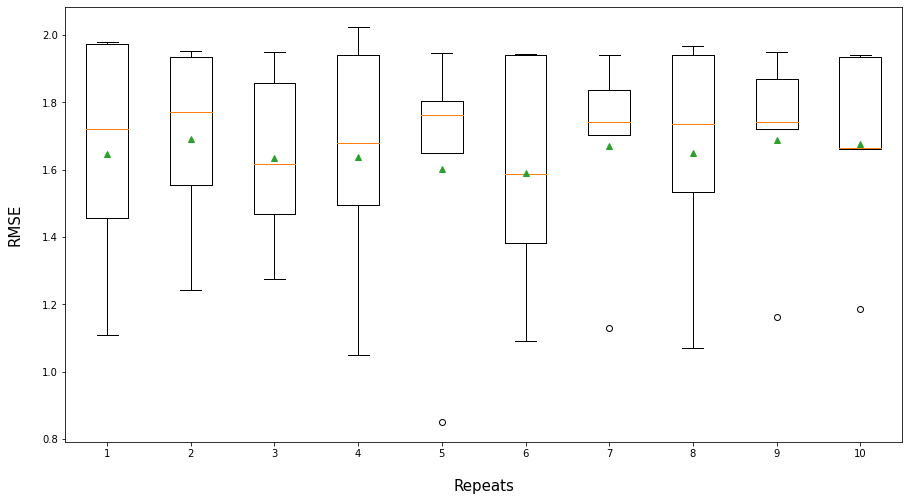

In [46]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [47]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv3, repeats)

RMSE: 1.633 (0.284)
RMSE: 1.285 (0.270)
RMSE: 1.209 (0.318)
RMSE: 1.669 (0.368)
RMSE: 1.197 (0.011)
RMSE: 0.995 (0.266)
RMSE: 1.459 (0.211)
RMSE: 1.109 (0.548)
RMSE: 1.010 (0.296)
RMSE: 1.070 (0.278)

RMSE: 1.263 (0.389)


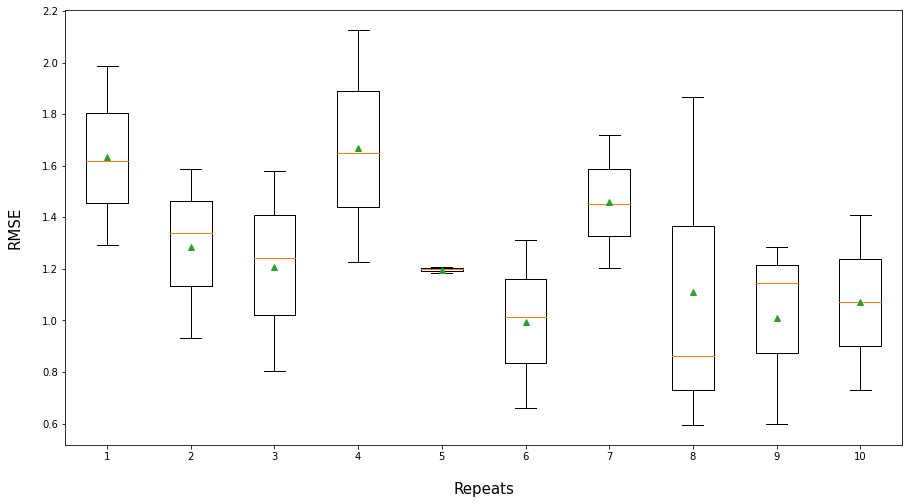

In [48]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [49]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = make_repeated_time_series_k_fold_non_canonical_transformer(x, y, train_period, test_period, gridcv3, repeats)

RMSE: 0.647 (0.000)
RMSE: 0.623 (0.000)
RMSE: 0.568 (0.000)
RMSE: 1.070 (0.000)
RMSE: 0.618 (0.000)
RMSE: 0.804 (0.000)
RMSE: 0.534 (0.000)
RMSE: 0.788 (0.000)
RMSE: 0.548 (0.000)
RMSE: 0.616 (0.000)

RMSE: 0.682 (0.156)


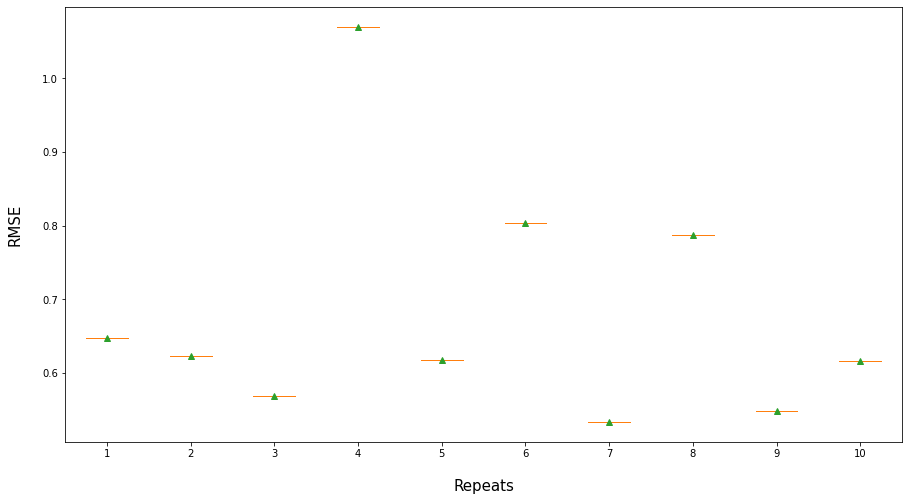

In [50]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h2>Times Series KFold Cross validation - Canonical Transformer</h2>

Here we will make a Times Series KFold Cross validation with all 3 datasets. Here we are using the <b>Blocking           Time Series Split</b> method. And with timeseries Split method

References

[1] https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4

[2] https://goldinlocks.github.io/Time-Series-Cross-Validation/

In [51]:
def make_repeated_time_series_k_fold(x, 
                                     y, 
                                     train_period,
                                     test_period,
                                     repeats=10,
                                     show_individual_results=True,
                                     show_final_result=True):
    results = []
    max_samples = x.shape[0]

    for _ in range(repeats):
        i = 0
        scores = []
        for _ in range(0, max_samples//train_period):
            x_train = x[i:i+train_period]
            y_train = y[i:i+train_period]
            x_test = x[i+train_period: i+train_period+test_period]
            y_test = y[i+train_period: i+train_period+test_period]
            i += train_period
            x_train = scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
            x_test = scaler.transform(x_test.reshape(-1, x_test.shape[-1])).reshape(x_test.shape)
            model = get_baseline_model(num_features=x_train.shape[-1], time_steps=x_train.shape[-2])
            model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=0)
            rmse = model.evaluate(x_test, y_test, verbose=0)
            scores.append(rmse[1])
        results.append(scores)
        if show_individual_results:
            print('RMSE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))
    if show_final_result:
        print('\nRMSE: %.3f (%.3f)' % (np.mean(results), np.std(results)))
    return results

<h3> Time Series Repeated KFold Cross Validation - df_no_r3d_r7d</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [52]:
df = df_no_r3d_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [53]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 1.382 (0.770)
RMSE: 2.063 (0.820)
RMSE: 1.230 (0.548)
RMSE: 1.708 (0.893)
RMSE: 1.378 (0.721)
RMSE: 1.503 (0.639)
RMSE: 1.685 (1.073)
RMSE: 1.555 (0.675)
RMSE: 1.710 (0.947)
RMSE: 1.991 (1.236)

RMSE: 1.621 (0.892)


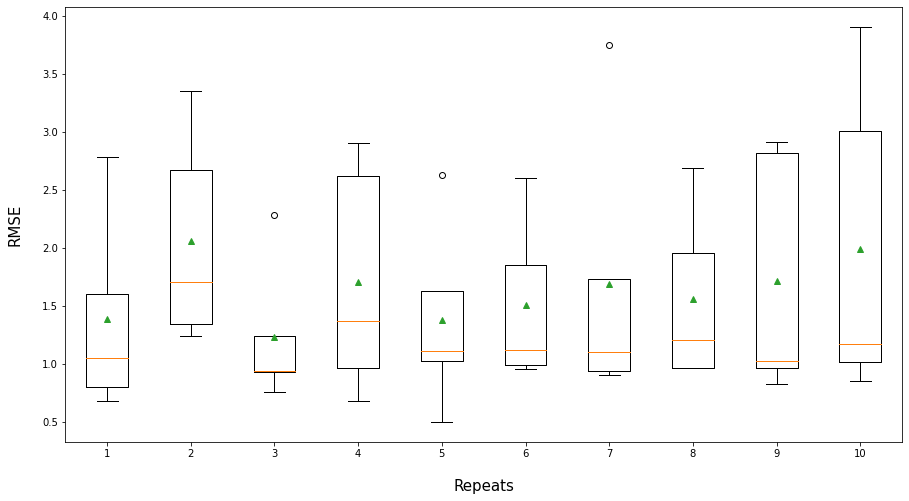

In [54]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [55]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 2.299 (0.512)
RMSE: 1.909 (0.443)
RMSE: 2.350 (0.615)
RMSE: 2.183 (0.669)
RMSE: 1.981 (0.433)
RMSE: 2.196 (0.605)
RMSE: 2.082 (0.596)
RMSE: 1.807 (0.577)
RMSE: 1.858 (0.490)
RMSE: 2.305 (0.888)

RMSE: 2.097 (0.625)


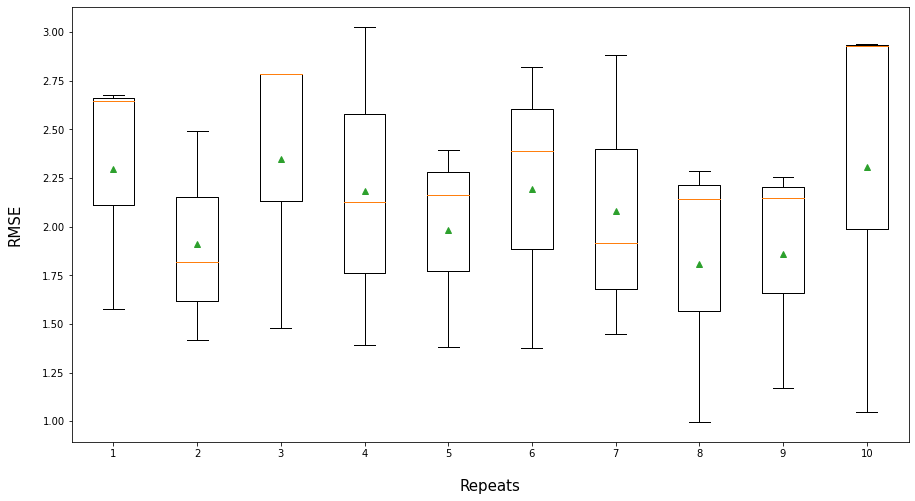

In [56]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [57]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 2.189 (0.000)
RMSE: 2.417 (0.000)
RMSE: 1.643 (0.000)
RMSE: 2.021 (0.000)
RMSE: 2.058 (0.000)
RMSE: 1.855 (0.000)
RMSE: 1.685 (0.000)
RMSE: 0.675 (0.000)
RMSE: 2.130 (0.000)
RMSE: 1.769 (0.000)

RMSE: 1.844 (0.452)


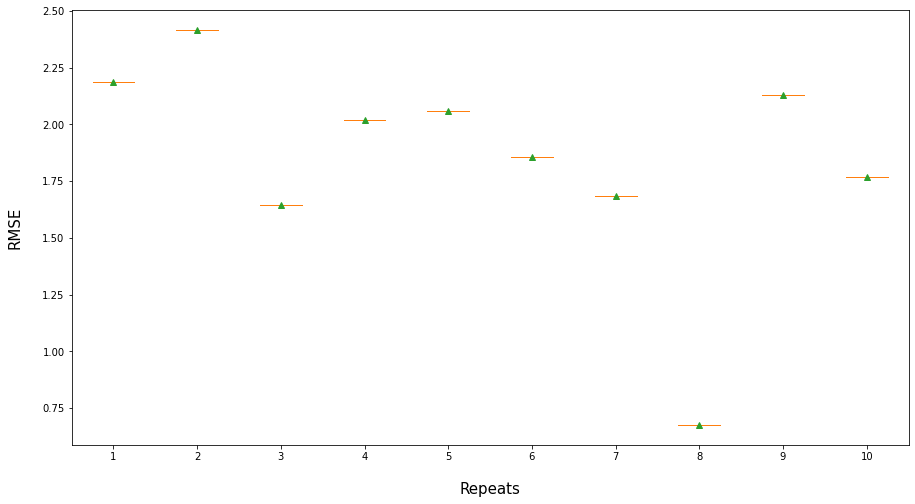

In [58]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h3> Time Series Repeated KFold Cross Validation - df_r3d_only</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D variable is considered.

In [59]:
df = df_r3d_only.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [60]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 1.667 (0.623)
RMSE: 1.745 (0.488)
RMSE: 1.585 (0.759)
RMSE: 2.191 (0.976)
RMSE: 1.704 (0.805)
RMSE: 1.676 (0.665)
RMSE: 1.754 (0.501)
RMSE: 2.052 (0.738)
RMSE: 1.718 (0.516)
RMSE: 1.809 (0.922)

RMSE: 1.790 (0.740)


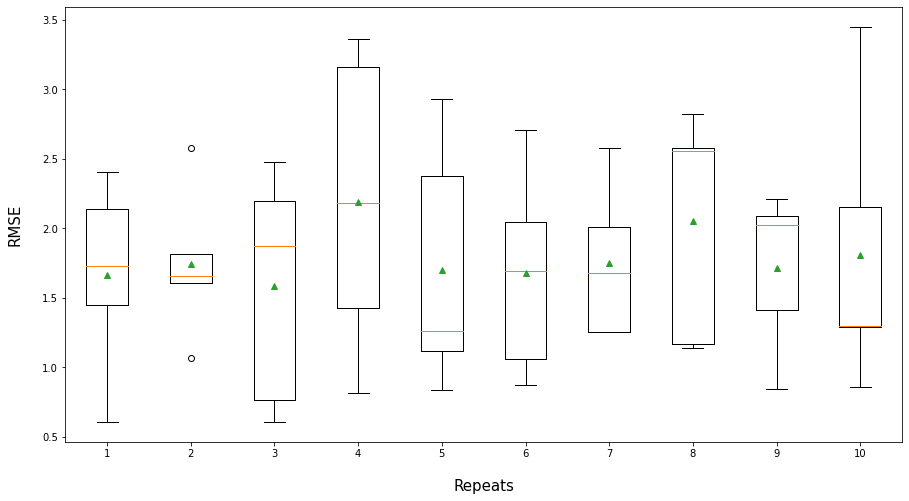

In [61]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [62]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 2.251 (0.292)
RMSE: 1.634 (0.288)
RMSE: 1.939 (0.521)
RMSE: 2.798 (0.312)
RMSE: 2.357 (0.554)
RMSE: 2.381 (0.738)
RMSE: 2.079 (0.843)
RMSE: 2.395 (0.768)
RMSE: 1.863 (0.358)
RMSE: 1.477 (0.540)

RMSE: 2.117 (0.674)


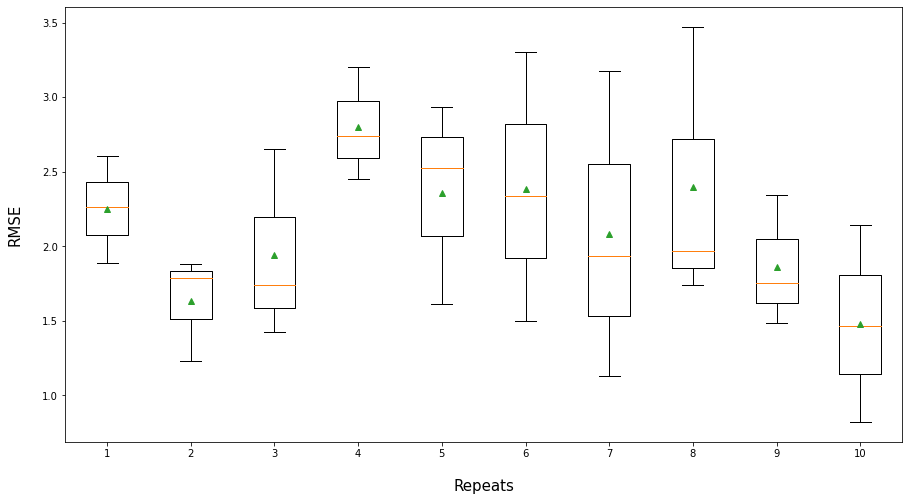

In [63]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [64]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 0.850 (0.000)
RMSE: 1.189 (0.000)
RMSE: 1.388 (0.000)
RMSE: 2.822 (0.000)
RMSE: 2.181 (0.000)
RMSE: 2.399 (0.000)
RMSE: 1.601 (0.000)
RMSE: 1.235 (0.000)
RMSE: 1.899 (0.000)
RMSE: 2.076 (0.000)

RMSE: 1.764 (0.585)


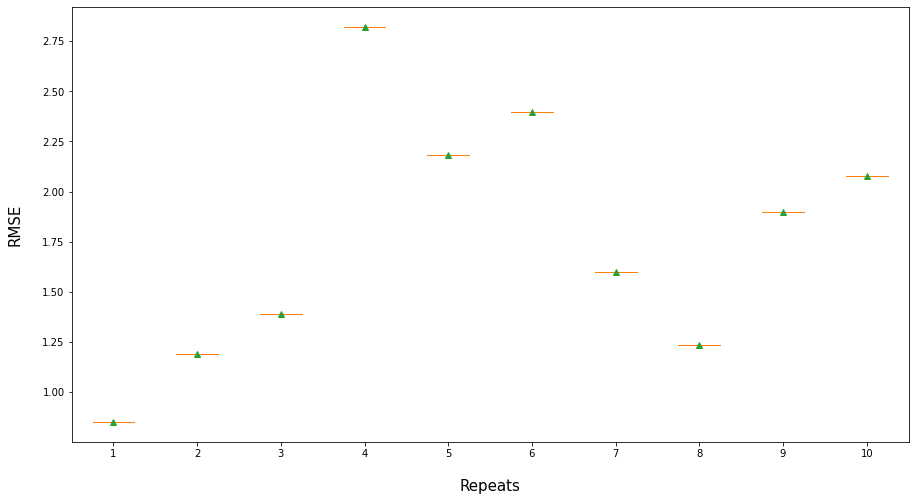

In [65]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h3> Time Series Repeated KFold Cross Validation - df_r3d_and_r7d</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D variables are considered.

In [66]:
df = df_r3d_and_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)
x, y = split_sequences(df.values, TIME_STEPS)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [67]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 1.820 (0.795)
RMSE: 2.163 (0.951)
RMSE: 1.895 (0.459)
RMSE: 1.357 (0.529)
RMSE: 2.140 (1.228)
RMSE: 1.671 (0.641)
RMSE: 1.930 (0.707)
RMSE: 1.781 (1.035)
RMSE: 1.902 (1.070)
RMSE: 1.948 (1.073)

RMSE: 1.861 (0.911)


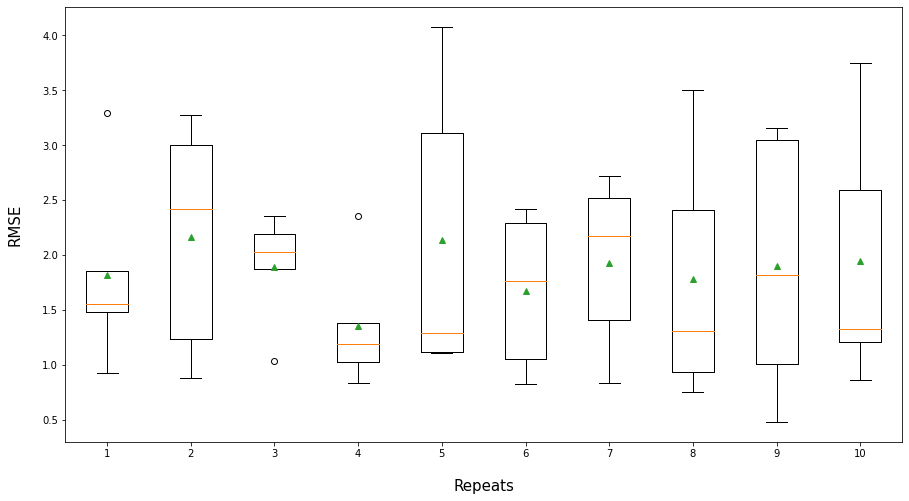

In [68]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [69]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 2.472 (0.989)
RMSE: 2.152 (0.705)
RMSE: 1.927 (0.969)
RMSE: 2.058 (0.591)
RMSE: 1.922 (0.568)
RMSE: 2.027 (0.488)
RMSE: 2.275 (0.570)
RMSE: 2.026 (0.837)
RMSE: 1.946 (0.355)
RMSE: 2.540 (0.360)

RMSE: 2.134 (0.711)


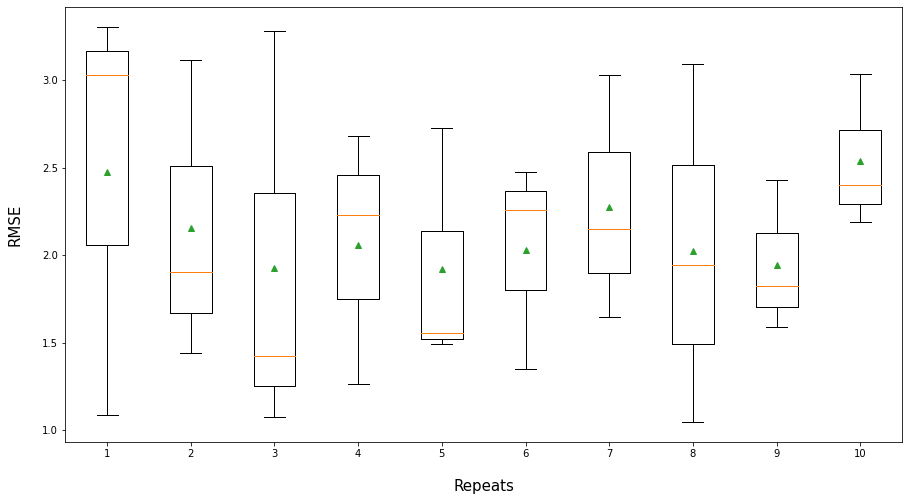

In [70]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [71]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months
repeats = 10
results = make_repeated_time_series_k_fold(x, y, train_period, test_period, repeats)

RMSE: 1.305 (0.000)
RMSE: 1.558 (0.000)
RMSE: 1.844 (0.000)
RMSE: 0.791 (0.000)
RMSE: 2.261 (0.000)
RMSE: 1.777 (0.000)
RMSE: 1.365 (0.000)
RMSE: 1.558 (0.000)
RMSE: 1.539 (0.000)
RMSE: 1.149 (0.000)

RMSE: 1.515 (0.382)


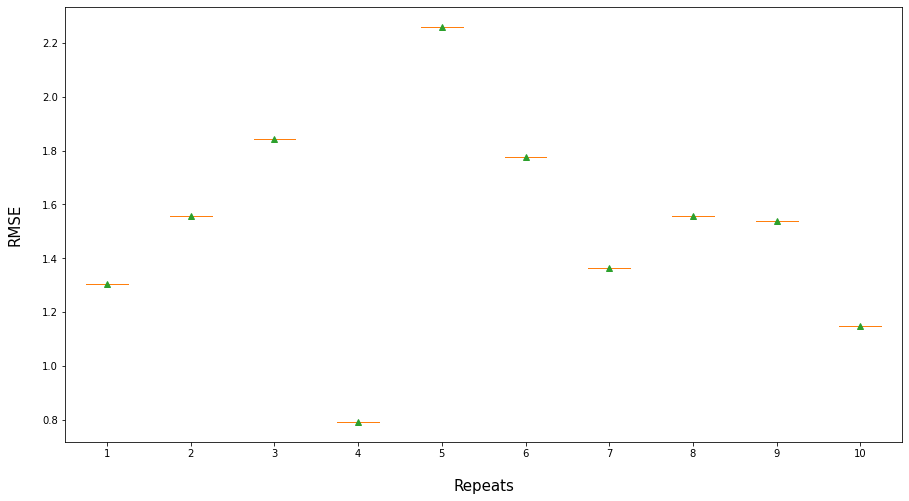

In [72]:
plt.figure(figsize=(15,8))
plt.ylabel('RMSE', labelpad=20, fontsize=15)
plt.xlabel('Repeats', labelpad=20, fontsize=15)
plt.boxplot(results, labels=[str(r) for r in range(1, repeats+1)], showmeans=True)
plt.show()

# Times Series Repeated KFold Cross validation - different Timesteps values

Here we will make a Times Series KFold Cross validation with all 3 datasets. Here we are using the Blocking Time Series Split method. And with timeseries Split method. We also do it with different number of timesteps


# Configs:

1. Train Period: [01-01-2019, 2021-05-02)

2. Test Period:  (2021-05-02, 2021-11-31]

3. TIMESTEPS: [1, 3, 5, 7, 10, 15, 20]

4. Epochs: 100

5. Batch size: 32

6. num heads: 2

7. FF Layers enc: 1

      7.1 Units 32

8. Optimization Algorithm: Adam
    
    8.1. Learning Rate: 1e-2

In [73]:
def make_timesteps_repeated_time_series_k_fold(df,
                                               train_period,
                                               test_period,
                                               repeats=10,
                                               timesteps_list=[3],
                                               show_results=True):
    results = {}
    
    for timesteps in timesteps_list:
        x, y = split_sequences(df.values, timesteps)
        scores = make_repeated_time_series_k_fold(x,
                                                  y,
                                                  train_period,
                                                  test_period,
                                                  repeats=10,
                                                  show_individual_results=False,
                                                  show_final_result=False)
        results[timesteps] = scores
        if show_results:
            print('TIMESTEPS: %d RMSE: %.3f (%.3f)' % (timesteps, np.mean(scores), np.std(scores)))
    return results

In [74]:
timesteps_list = [1, 3, 5, 7, 10, 15, 20]
repeats = 10

<h3> Time Series Repeated KFold Cross Validation with vary timesteps - df_no_r3d_r7d</h3>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [75]:
df = df_no_r3d_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [76]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month

<b>Baseline model</b>

In [77]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 1.833 (0.997)
TIMESTEPS: 3 RMSE: 1.831 (0.885)
TIMESTEPS: 5 RMSE: 1.826 (1.071)
TIMESTEPS: 7 RMSE: 2.001 (0.815)
TIMESTEPS: 10 RMSE: 2.245 (1.041)
TIMESTEPS: 15 RMSE: 2.004 (0.669)
TIMESTEPS: 20 RMSE: 1.959 (0.685)


<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [78]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month

<b>Baseline model</b>

In [79]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 1.680 (0.422)
TIMESTEPS: 3 RMSE: 2.191 (0.592)
TIMESTEPS: 5 RMSE: 2.446 (1.017)
TIMESTEPS: 7 RMSE: 2.577 (1.236)
TIMESTEPS: 10 RMSE: 2.785 (1.640)
TIMESTEPS: 15 RMSE: 2.102 (1.156)
TIMESTEPS: 20 RMSE: 2.059 (1.248)


<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [80]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months

In [81]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 1.735 (0.179)
TIMESTEPS: 3 RMSE: 1.777 (0.557)
TIMESTEPS: 5 RMSE: 2.314 (0.358)
TIMESTEPS: 7 RMSE: 2.267 (0.447)
TIMESTEPS: 10 RMSE: 2.673 (0.528)
TIMESTEPS: 15 RMSE: 3.189 (0.705)
TIMESTEPS: 20 RMSE: 2.546 (0.545)


<h3> Time Series Repeated KFold Cross Validation - df_r3d_only</h3>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D variable is considered.

In [82]:
df = df_r3d_only.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [83]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month

<b>Baseline model</b>

In [84]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 1.837 (1.040)
TIMESTEPS: 3 RMSE: 1.704 (0.731)
TIMESTEPS: 5 RMSE: 1.666 (0.762)
TIMESTEPS: 7 RMSE: 2.043 (0.865)
TIMESTEPS: 10 RMSE: 2.255 (0.928)
TIMESTEPS: 15 RMSE: 1.760 (0.683)
TIMESTEPS: 20 RMSE: 1.841 (0.800)


<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [85]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month

<b>Baseline model</b>

In [86]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 1.754 (0.457)
TIMESTEPS: 3 RMSE: 2.239 (0.820)
TIMESTEPS: 5 RMSE: 2.405 (0.958)
TIMESTEPS: 7 RMSE: 2.361 (1.306)
TIMESTEPS: 10 RMSE: 2.169 (1.229)
TIMESTEPS: 15 RMSE: 2.058 (1.020)
TIMESTEPS: 20 RMSE: 1.688 (0.883)


<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [87]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months

<b>Baseline model</b>

In [88]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 1.722 (0.251)
TIMESTEPS: 3 RMSE: 2.000 (0.317)
TIMESTEPS: 5 RMSE: 2.461 (0.468)
TIMESTEPS: 7 RMSE: 2.683 (0.315)
TIMESTEPS: 10 RMSE: 2.715 (0.405)
TIMESTEPS: 15 RMSE: 2.770 (0.596)
TIMESTEPS: 20 RMSE: 2.366 (0.807)


<h3> Time Series Repeated KFold Cross Validation - df_r3d_and_r7d</h3>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D variables are considered.

In [89]:
df = df_r3d_and_r7d.copy()
columns = list(df.columns.drop(['R28D']))
columns.append('R28D')
df = df.reindex(columns=columns)
df = df.drop(['Data/Hora'], axis=1)

<h4>Experiment 1</h4>
    
<b>Train 6 months and predicts one month every year</b>

In [90]:
train_period = 90 # 6 months of data since the data is spaced every 2 days
test_period = 15 # 1 month

<b>Baseline model</b>

In [91]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 1.984 (1.179)
TIMESTEPS: 3 RMSE: 1.724 (0.845)
TIMESTEPS: 5 RMSE: 1.718 (0.664)
TIMESTEPS: 7 RMSE: 1.906 (0.698)
TIMESTEPS: 10 RMSE: 1.999 (0.916)
TIMESTEPS: 15 RMSE: 2.086 (0.868)
TIMESTEPS: 20 RMSE: 2.003 (0.859)


<h4>Experiment 2</h4>
    
<b>Train 11 months and predicts one month every year</b>

In [92]:
train_period = 165 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 15 # 1 month

<b>Baseline model</b>

In [93]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 1.685 (0.481)
TIMESTEPS: 3 RMSE: 2.066 (0.623)
TIMESTEPS: 5 RMSE: 2.339 (1.184)
TIMESTEPS: 7 RMSE: 2.369 (1.483)
TIMESTEPS: 10 RMSE: 2.359 (1.515)
TIMESTEPS: 15 RMSE: 1.914 (1.201)
TIMESTEPS: 20 RMSE: 2.145 (1.682)


<h4>Experiment 3</h4>
    
<b>Train 2 years and 10 months and predicts october and november of 2021</b>

In [94]:
train_period = 495 # 11 months of data since the data is spaced every 2 days (180 + 150)/2
test_period = 30 # 2 months

<b>Baseline model</b>

In [95]:
results = make_timesteps_repeated_time_series_k_fold(df, train_period, test_period, repeats, timesteps_list, True)

TIMESTEPS: 1 RMSE: 1.595 (0.138)
TIMESTEPS: 3 RMSE: 1.594 (0.427)
TIMESTEPS: 5 RMSE: 2.322 (0.433)
TIMESTEPS: 7 RMSE: 2.700 (0.417)
TIMESTEPS: 10 RMSE: 2.882 (0.329)
TIMESTEPS: 15 RMSE: 2.954 (0.480)
TIMESTEPS: 20 RMSE: 2.854 (0.734)
